## Uncertainty Quantification Methods
review sur l'uncertainty quantification en deep learning [2021](https://arxiv.org/pdf/2011.06225.pdf)

Deux types d'incertitude : **aleatoric** et **epistemic**
- Aleatoric Uncertainty :  également appelé incertitude sur la donnée, et donc produit innévitablement de l'incertitude sur la prédiction. Ce n'est pas une propriété du model, mais bien un problème inhérent à la distribution de la donnée.
- Epistemic Uncertainty :  également appelé incertitude sur la connaissance, elle est lié au modèle, et également à la donnée, par exemple si la donnée est incomplète / tronqué 
Nous allons nous intéressé l'incertitude aleatoric,
On va récupérer différentes méthodesde quantification d'incertitude.  Cela va nous servir de baseline, a comparer également avec notre baseline de modèle.

Questions sous-jacentes : 
- Est-ce qu'il y a une méthode préférable pour tous les modèles de DL, ou est-ce que la méthode diffère selon le modèle considéré ? 
- Est-ce que l'intervalle d'incertitude est réellement adapté ? Par exemple, si on a un événement 'atypique', est-ce que l'interval est adapté en conséquence ? Comment peut-il prendre l'information ?
- Dans le cas de pics, on veut un PI avec une plus forte erreur haute que basse. Vérifier que c'est bien le cas. 

Nous avons différentes méthodes possibles. Les suivantes viennent du papier [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf):
- Historical data-based method   
- Bayesian uncertainty quantification
- Monte Carlo Dropout   [UvA DL Notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html)
- Deep quantile regression (DQR)
- Conformal prediction 
- QuanTraffic (celle du papier)


### Métriques d'évaluation d'un 'bon' PI : 
On veut que le PI soit le plus restreint possible, mais également qu'il contiennent bien la prédiction et la valeur réelle dans x% des cas. Avec x la longueur de l'interval $[\alpha /2, (1-\alpha /2)]$ basé sur le quantile $\alpha$ 

Les métriques courament utilisées : 
- MPIW : c'est la moyenne de la taille des intervalles [lower band ; upper band] (Mean Prediction INterval Width)
- PICP : Moyenne des 'bonne prédiction'. Où une bonne prédiction est 1 si la valeur réelle est dans [lower band ; upper band], 0 sinon. (rediction Interval Coverage Probability)

#### Autres exemples d'uncertainty quantification de ce notebook :  
- Multiple forward Pass (donc peut être gourmant en coût mémoire et computation): 
    - Deep Ensemble  [UvA DL Notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html)
    - Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles [Deep Ensembles, Nov 2017](https://arxiv.org/pdf/1612.01474.pdf)
        - Utilise une architecture Deep constante (1-layer FC network avec 50 ou 100hidden unit). Comparare avec Probabilistic Backpropagation (PBP) et MC-Dropout
- Single Forward Pass pendant la phase de test: 
    - Simple and Principled Uncertainty Estimation with Deterministic DL via Distance Awareness [SNGP, Oct 2020](https://arxiv.org/pdf/2006.10108.pdf)
        - Remplace l'output sortie par une Gaussian Process Layer (GP-layer), et applique une Spectral Normalization (SP)

- Ne sait pas encore : 
    - Simultaneous Quantile Regression (for aleatoric uncertainty) [SQR](https://arxiv.org/pdf/1811.00908.pdf)
    - Probabilistic Backpropagation for Scalable learning of Bayesian NN [Jul 2015](https://arxiv.org/pdf/1502.05336.pdf)
    - Boostrap 
    - Gaussian Mixture Model 
    - MC Batch Normalization (MCBN)
    - Markov Chain MC (MCMC)


#### Calibration et overconfidence
Semble conserner des problèmes de **classification** (multi-class classification). Mais autant garder ça sous le coude : 
- [Expectation consistency for calibration of neural networks, Clarté et al., 2023](https://proceedings.mlr.press/v216/clarte23a/clarte23a.pdf)
- [On calibration of Modern Neural Network, Guo et al., 2017](https://arxiv.org/pdf/1706.04599.pdf)



## Preprocess the data if not already done: 

In [1]:
from preprocess_subway_15 import replace_negative, load_data_and_pivot
from datetime import datetime 
import pandas as pd 
# Paths
folder_path = 'data/'
file_name = 'Metro_15min_mar2019_mai2019.csv'

#Init and load data: 
time_step_per_hour=4
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

train_prop = 0.6  #0.6
calib_prop = 0.4
valid_prop = 0.2  #0.2

# Load subway in data:
def preprocess_subway_in(folder_path,file_name,time_step_per_hour,start = datetime(2019,3,16),end = datetime(2019,6,1)):
    reindex = pd.date_range(start,end,freq = f'{60/time_step_per_hour}min')
    subway_in,subway_out = load_data_and_pivot(folder_path, file_name, reindex)
    subway_in = replace_negative(subway_in,method = 'linear') 
    return subway_in

subway_in = preprocess_subway_in(folder_path,file_name,time_step_per_hour,start = datetime(2019,3,16),end = datetime(2019,6,1))
subway_in.to_csv('data/preprocessed_subway_15_min.csv')

c:\Users\romai\Code\prediction-validation\DL_utilities.py:156: SyntaxWarning: invalid escape sequence '\e'
  print(f"epoch: {epoch} \n min\epoch : {'{0:.2f}'.format((time.time()-t0)/60)}")


Training and Hyper-parameter tuning with Ray is not possible


## Load DataSet, set all the parameters: 

In [1]:
import pandas as pd 
from datetime import datetime
from load_DataSet_subway_15 import load_normalized_dataset
from DL_utilities import DictDataLoader,Trainer,PI_object,QuantileLoss
import numpy as np 
import os 
import sys
import torch
import torch.nn as nn
from torch.optim import SGD 
import random

try:
    from plotting import plot_loss
    import matplotlib.pyplot as plt 
except : 
    print('matplotlib.pyplot is not available')

notebook_dir = os.getcwd()
code_dir = os.path.abspath(os.path.join(notebook_dir, '../'))
if code_dir not in sys.path:
    sys.path.insert(0,code_dir)

# Import models : 
from dl_models.CNN_based_model import CNN
from dl_models.MTGNN import gtnet
from dl_models.RNN_based_model import RNN

# Import config
from config import get_config

# Paths
folder_path = 'data/'
file_name = 'preprocessed_subway_15_min.csv'

#Init and load data: 
time_step_per_hour=4
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

train_prop = 0.6  #0.6
calib_prop = 0.4
valid_prop = 0.2  #0.2
window_pred = np.arange(2*96)

# Load subway in data:
subway_in = pd.read_csv(folder_path+file_name,index_col = 0)
subway_in.columns.name = 'Station'
subway_in.index = pd.to_datetime(subway_in.index)

# Invalid dates : 
invalid_dates = pd.date_range(datetime(2019,4,23,14),datetime(2019,4,28,14),freq = f'{60/time_step_per_hour}min')

# Load DataSet and Normalize it: 
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,train_prop,step_ahead,H,D,W,invalid_dates)


# Hyperparameter
batch_size = 32
epochs = 50
lr = 1e-4
momentum = 0.99 # 0.9

H_dims = [16,16]
c_in = 1
C_outs = [16,1]

In [3]:
# Generate a dataloader object, which propose different validation (classic, K-fold Cross ...). 
# data_loader is a dictionnary containing train, valid, and test dataset
data_loader_obj = DictDataLoader(U,Utarget,train_prop,valid_prop,validation = 'classic', shuffle = True,calib_prop=calib_prop)
data_loader = data_loader_obj.get_dictdataloader(batch_size)


model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1)

In [4]:
def train_valid_model(model,data_loader,epochs,lr,momentum, loss_function = nn.MSELoss() ):
    optimizer = SGD(model.parameters(),lr=lr,momentum = momentum)

    # Training and validation 
    trainer = Trainer(model,data_loader,epochs,optimizer,loss_function,scheduler = None)
    trainer.train_and_valid(mod = 1000)

    return(trainer)

def train_valid_test_model(model,data_loader,epochs,lr,momentum, test = True, plot = True, window_pred = None,    loss_function = nn.MSELoss() ):
    # Testing 
    trainer = train_valid_model(model,data_loader,epochs,lr,momentum,loss_function = nn.MSELoss() )
    if test: 
        (test_pred,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])
        if plot: 
            plot_loss(trainer,test_pred,Y_true, window_pred)
        return(trainer,test_pred,Y_true,df_metrics)
    return(trainer)


start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.3min 


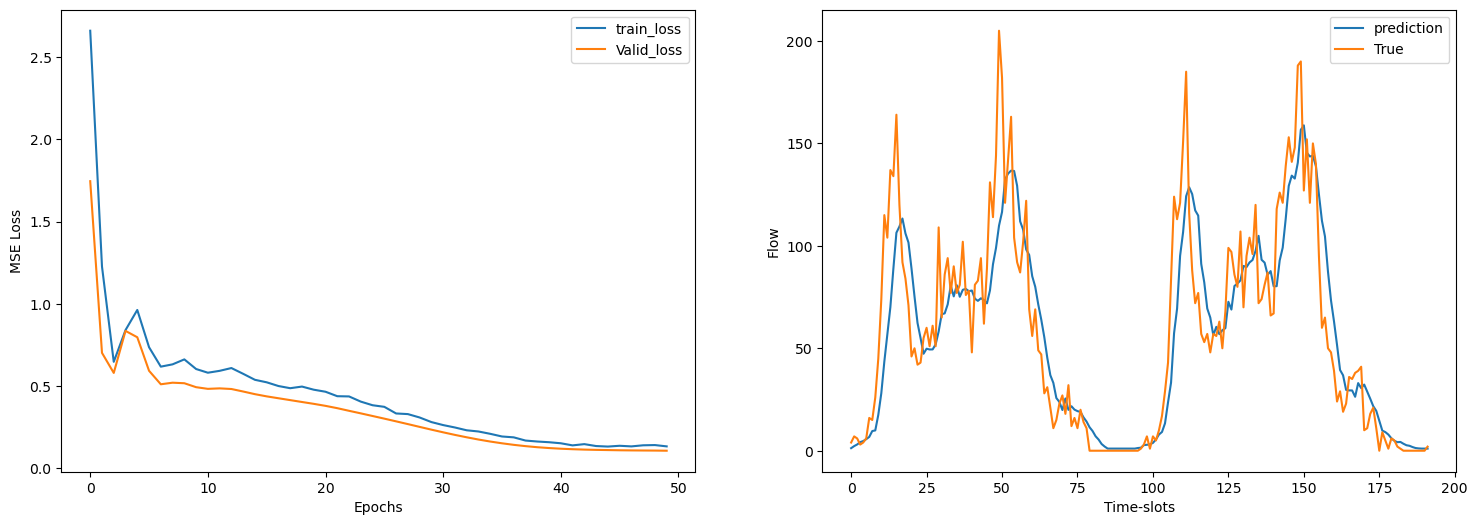

In [5]:
(trainer,test_pred,Y_true,df_metrics) = train_valid_test_model(model,data_loader,epochs,lr,momentum, window_pred=window_pred)

# Deep Ensemble 
L'idée est de prédire un $\textit{ensemble}$ de modèles, tous avec la même configuration.

On veut quantifier l'incertitude du modèle sur la prédiction. On peut donc définir la "bande d'incertitude" de l'ensemble.

Une manière simple est de regarder la moyenne des prédiction, avec $\pm \lambda$ std

In [5]:
ensemble_size = 5
ensemble = [CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1)  for _ in range(ensemble_size)]
Y_preds = []
for model in ensemble:
    (trainer,test_pred,Y_true,df_metrics) = train_valid_test_model(model,data_loader,epochs,lr,momentum,test = True, plot = False)
    Y_preds.append(test_pred[:,0,0])
L_preds = np.array([y.detach().numpy() for y in Y_preds])


start training
epoch: 0 
 min\epoch : 0.00
Estimated time for training: 0.2min 
start training
epoch: 0 
 min\epoch : 0.00
Estimated time for training: 0.2min 
start training
epoch: 0 
 min\epoch : 0.00
Estimated time for training: 0.2min 
start training
epoch: 0 
 min\epoch : 0.00
Estimated time for training: 0.2min 
start training
epoch: 0 
 min\epoch : 0.00
Estimated time for training: 0.2min 


In [12]:
# Plotting
def plot_uncertainty_bands(L_preds,Y_true,window_pred = np.arange(2*96),method='MC dropout'):
    y_mean = L_preds.mean(axis = 0)
    y_std = L_preds.std(axis = 0)
    fig, ax = plt.subplots(figsize = (18,6))
    pred_mean = y_mean[window_pred]
    pred_std = y_std[window_pred]
    y_true = Y_true[window_pred][:,0,0]

    ax.plot(np.arange(len(pred_mean)),pred_mean, label = f'mean prediction',alpha=1, color='#86cfac')
    ax.plot(np.arange(len(y_true)),y_true,label = 'True')

    if method == 'MC dropout':
        for alpha in [1,2,3]:
            lower = pred_mean-alpha*pred_std
            upper = pred_mean+alpha*pred_std
            picp = ((lower < y_true.numpy())&(y_true.numpy()<upper)).sum()/len(lower)
            mpiw = (upper-lower).mean()                             
            grid = np.arange(len(pred_mean)).ravel()
            ax.fill_between(grid,lower,upper, label = f"{alpha} std, PICP:{'{:.2%}'.format(picp)}, MPIW: {'{:.2f}'.format(mpiw)}",alpha=0.6/alpha, color='#86cfac')

    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Flow')
    ax.legend()

    plt.show()

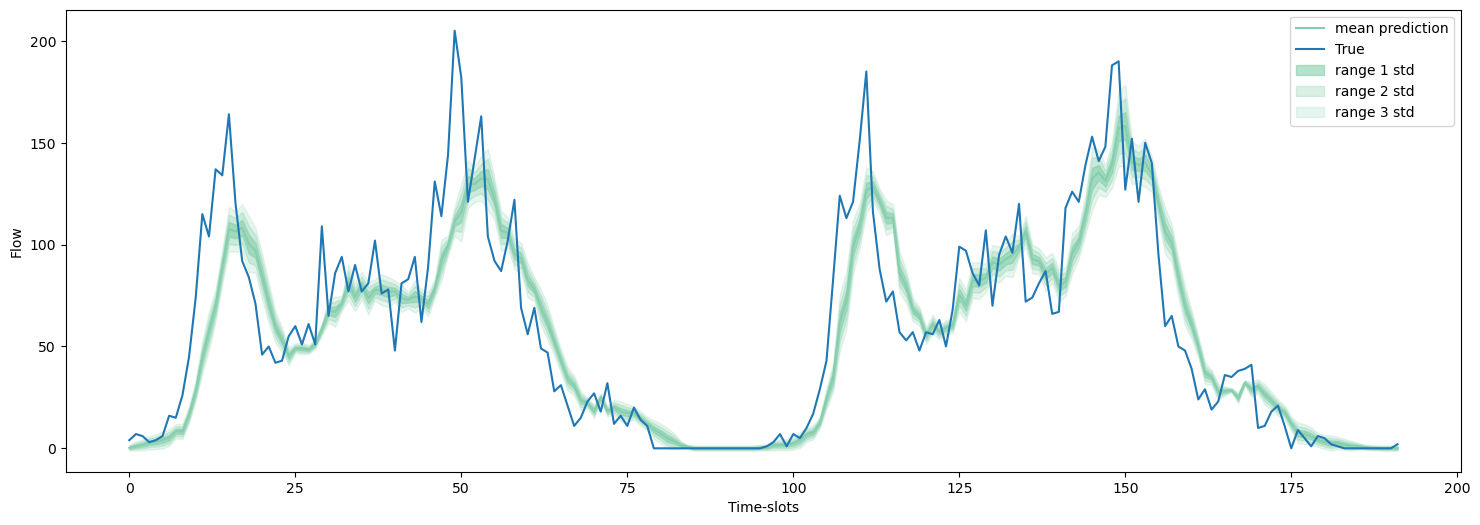

In [7]:
plot_uncertainty_bands(L_preds,Y_true,window_pred = np.arange(2*96))

# Monte Carlo Dropout
En fait, la technique précédente de l'ensemble Learning est efficace mais très couteuse. C'est pourquoi il faut en définir d'autres.

La Monte Carlo Dropout propose d'utiliser une architecture avec des dropout, et une fois qu'elle est entrainer, utiliser le test avec les dropout actif. Il suffit alors de générer une centaine de test, sur ce même modèle déjà entrainé. 

**Limites et Discussions** On pourrait dire qu'on 'limite les performances du modèles' à chaque fois qu'on passe la dataset de test dans le model avec dropout. 
Problèmes de définission mathématiques. Aleatoric et Epistemic Uncertainty ne sont pas définies rigoureusement. Il y a une discussion a ce propopos [reddit](https://www.reddit.com/r/MachineLearning/comments/7bm4b2/d_what_is_the_current_state_of_dropout_as/), où ils parlent de Risk et d'Uncertainty, de ce qui est capturé par le MC dropout, et de leur différences. Risk et Uncertainty sont deux choses fondamentalements différentes, que l'on peut définir précisément dans le contexte de la Bayesian Inference. [Gal & Ghahramani, 2016](https://arxiv.org/pdf/1506.02142.pdf) ont considéré que le test-time dropout pouvait être considéré comme une Baysian approximation. [Osband 2016](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf) a publié une note, et utilise une [figure](http://htmlpreview.github.io/?https://github.com/yaringal/HeteroscedasticDropoutUncertainty/blob/master/demos/homoscedastic_dropout_reg_DM_relu.html) intéressante. Il explique que de nombreuses méthodes présentée comme approximation de l'uncertainty d'un model sont en fait une approximation du risk du model. Il discute aussi de la différence entre distribution à posteriori de la moyenne, et distribution de la sortie d'un model. Il identifique :
- le risk comme quelque chose d'inhérent à la stochasticité du model   (Le lancé d'une pièce présente un risque, une chance sur deux pour être 0 ou 1, et alors un agent apprenant - lanceur ou model ?-  peut être incertain de p)
- l'uncertitude comme une confusion sur les paramètres que l'ont devrait fixer au model (l'incertitude capture la la variabilité de la croyance (à posteriori) du lanceur, et elle peut être résolue par une analyse stat des données)
Dans le cas du lancé de pièce, avec une modélisation plus détaillée de la physique/dynamique derrière le lancé de pièce, on peut réduire le risque, et il peut n'être plus risqué du tout.


### Model.train() a été set au lieu de model.eval(). Je suis sur d'activer les dropouts, mais j'active aussi ici les autres régularisations, que je ne veux pas forcément.

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.3min 


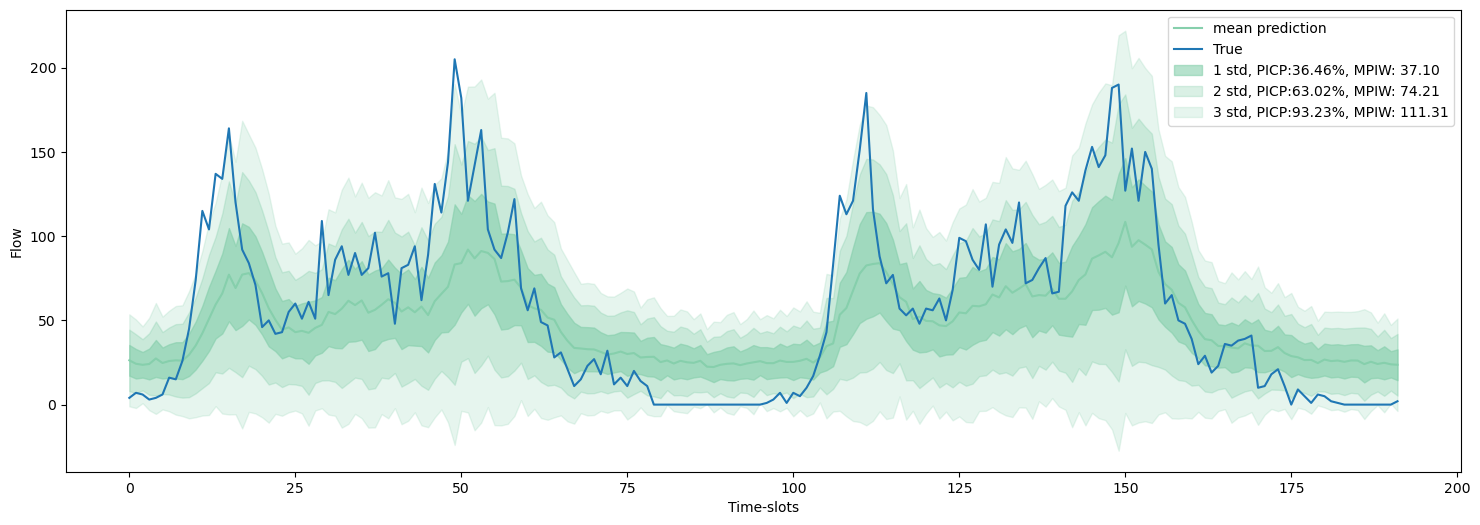

In [13]:
# Load, train and valid model 
model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1,dropout = 0.3)
(trainer,test_pred,Y_true,df_metrics) = train_valid_test_model(model,data_loader,epochs,lr,momentum,test = True, plot = False)

# Test model N times, with dropout_on : 
L_preds = np.array([trainer.testing(dataset,metrics= ['mse','mae'],allow_dropout = True)[0][:,0,0].detach().numpy() for _ in range(100)]) # trainer.testing(dataset,metrics= ['mse','mae'],allow_dropout = True)[0] = test_pred
plot_uncertainty_bands(L_preds,Y_true,window_pred = np.arange(2*96))

# Inductive Conformal Prediction: 
Approche statistique de l'Uncertainty quantification [Vovk et al., 2008](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf).

L'inductive Conformal Prediction se fait après le total entrainement du modèle.  Elle est **inductive** par opposition à la **Transductive conformal prediction**. Dans l'inductive on entraine notre modèle pour qu'il nous fournisse la 'règle' derrière la distribution des donnée. On applique ensuite sur la test set pour obtenir les prédiction. Toutes les informations nécessaire sont contenues dans le modèle, et le training set n'intervient plus lors de la prédiction du test set. Dans le cas de la transductive inference, on prend un sample de test, et le training set nous oriente sur la prédiction.

**|!| Apparemment il y a aussi une difference entre 'split'/'inductive' et 'full' method. Dans [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf) ils écrivent : 'we will restrict our attention to split conformal prediction and refer the reader to [3, 15] for a more detailed comparison between the two methods [Lei, 2017, Book](https://arxiv.org/pdf/1604.04173.pdf) et [Vovk et al., 2005, Book](https://www.researchgate.net/publication/223460765_Algorithmic_Learning_in_a_Random_World)'** Par exemple, l'algo de la 'full' conformal prediction doit traiter les données de manière interchangeable.

Méthode : 
---
Permet de construire des bandes d'incertitudes autour de nos prédictions, sans modifier la prédiction du modèle. C'est obtenu en comparant les True / Predicted Values sur un certain ensemble de donnée. On en déduit un quantile empirique. A la comparaison entre la valeur prédite et la valeur réelle on y attribut un score, le 'conformity score', d'où le nom de la méthode.

On veut que pour chaque test sample $(X_{n+1},Y_{n+1})$: 
$$ \mathbb{P}(Y_{n+1} \in \hat{C}(X_{n+1})) \ge 1-\alpha$$

C'est à dire, que dans plus de $(1-\alpha)\%$ des cas, notre bande d'incertitude $\hat{C}$ autour de la prédiction, contient $Y_{n+1}$

Le set de donnée est séparée en plusieurs partie.
- **Training set** qui est lui même split en :
    - Proper Training set  $\mathcal{D}_1 = \{(X_i,Y_i),i\in \mathcal{I_1} \}$
    - Calibration set (un type de set de validation) $\mathcal{D}_2 = \{(X_i,Y_i),i\in \mathcal{I_2} \}$
- **Validation set** $\mathcal{D}_3 = \{(X_i,Y_i),i\in \mathcal{I_3} \}$
- **Test set** $\mathcal{D}_4 = \{(X_i,Y_i),i\in \mathcal{I_4} \}$
- $\mathcal{D}_1,\mathcal{D}_2,\mathcal{D}_3,\mathcal{D}_4$ forment une partition de l'ensemble des couples (séquences d'entrainement, valeur réelle).
    
Le Calibration set est généralement un set randomly selected. 

### Conformal prediction procedure : 
- On défini le **conformity scores**, qui est ici simplement le residuel : $y - \hat{y}$
- On choisi le quantile $q \in [0,1]$
- On compute le quantile tensor, et il servira à définir la bande sup et bande inf de notre prédiction.

On peut très bien imaginer faire la quantile regression non pas pour l'ensemble des time-slots, mais seulement sur des groupes de times-slots (dont certains groupes identifiée comme 'problématique', obtenue avec un clustering sur le calendrier, lié à des évenements et des stations ...)

### Focus sur la 'split conformal prediction' 
tiré de [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf).

Soit $\mathcal{A}$ un algo de regression, le modèle de regression est entrainé sur le proper training set : $$\hat{\mu}(x) \longleftarrow \mathcal{A}(\{(X_i,Y_i),i\in \mathcal{I}_{1} \})$$

Puis, les absolute residuals sont calculés sur le Calibration set : $$R_{i} = |Y_i - \hat{\mu} (X_i)|,\phantom{abc} i\in \mathcal{I}_2$$

Pour $\alpha \in [0,1]$, on calcule le quantile d'ordre $1-\alpha$ de la distribution empirique des absolute residuals : $$Q_{1-\alpha}(R,\mathcal{I}_2) = (1-\alpha)\left( 1+\frac{1}{|\mathcal{I}_2 |} \right) ^{th}\text{ quantile empirique de } \{R_i, i\in \mathcal{I}_2\} $$ 

Et alors, on déduit le PI pour un nouveau point $X_{n+1}$ en tant qu'interval de largeur $2Q_{1-\alpha}$ et centré sur $\hat{\mu}$:  $$C(X_{n+1}) =[\hat{\mu}(X_{n+1}) - Q_{1-\alpha}(R,\mathcal{I}_2),\phantom{a} \hat{\mu}(X_{n+1}) + Q_{1-\alpha}(R,\mathcal{I}_2)]  $$
Cet interval [satisfait l'hyppothèse de recouvrement](https://www.researchgate.net/publication/223460765_Algorithmic_Learning_in_a_Random_World) $\mathbb{P}\{Y \in \hat{C}(x) | X=x \} \ge 1-\alpha $. Cependant, il est largement limité dans le sens où la largeur de l'interval est indépendant de $X_{n+1}$. Ce qui amène [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf) à proposer la Conformalized Quantile Regression (CQR), dont la largeur de l'interval serait variable.
 



In [5]:
from matplotlib.ticker import PercentFormatter
def plot_conformal_bands(preds,Y_true,q,pi,conformity_scores,window_pred = np.arange(2*96),bins = 20):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (18,6))
    pred = preds[window_pred][:,0,0]
    y_true = Y_true[window_pred][:,0,0]
    lower = pi.lower[window_pred][:,0,0]
    upper = pi.upper[window_pred][:,0,0]
    Q = pi.Q[0,0,0]


    ax1.plot(np.arange(len(pred)),pred, label = f'Prediction',alpha=1, color='#86cfac')
    ax1.plot(np.arange(len(y_true)),y_true,label = 'True')


    grid = np.arange(len(pred)).ravel()
    ax1.fill_between(grid,lower,upper, label = f"PI: {'{:.2f}'.format(q.item())}-th empirical quantile: {'{:.0f}'.format(Q.item())} \n PICP: {'{:.2%}'.format(pi.picp)} \n MPIW: {'{:.2f}'.format(pi.mpiw)}",alpha=0.6, color='#86cfac')

    ax1.set_xlabel('Time-slots')
    ax1.set_ylabel('Flow')
    ax1.legend()

    #histogram
    conformity_scores_first_station = conformity_scores[:,0,0]
    ax2.hist(conformity_scores_first_station,bins = bins, label = 'Conformity Scores distirbution',density = True)
    ax2.plot([Q,Q],[0,0.2],color = 'red', linestyle = 'dashed',label = f"Q={'{:.0f}'.format(Q.item())} is the {'{:.2f}'.format(q.item())}-th quantile")
    ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Proportion')
    ax2.legend()

    plt.show()

In [17]:
'''Let's Keep the trained model.
    - We use the calibration set (x_cal,y_cal) to calibrate the model.
        - First we predict 'y_cal_pred', unormalize it, and compute residual
        - Then we compute 'Q' which represent (for each station) the empirical (1-alpha)th quantile of the residual
        - Finally, we use the test set. We predict the expected value with the model, and we compute the PI [prediction(X) - Q, prediction(X) + Q]
'''

model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1)
trainer = train_valid_model(model,data_loader,epochs,lr,momentum,loss_function = nn.MSELoss() )
# Init
alpha = 0.1
#alpha = 0.9
Q = trainer.conformal_calibration(alpha,dataset)

# Test
(preds,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'],allow_dropout = False)
#preds = torch.cat([preds - Q,preds + Q],dim = -1)

# PI 
pi = PI_object(torch.cat([preds,preds],dim=-1) ,Y_true,alpha,Q=Q)

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.3min 


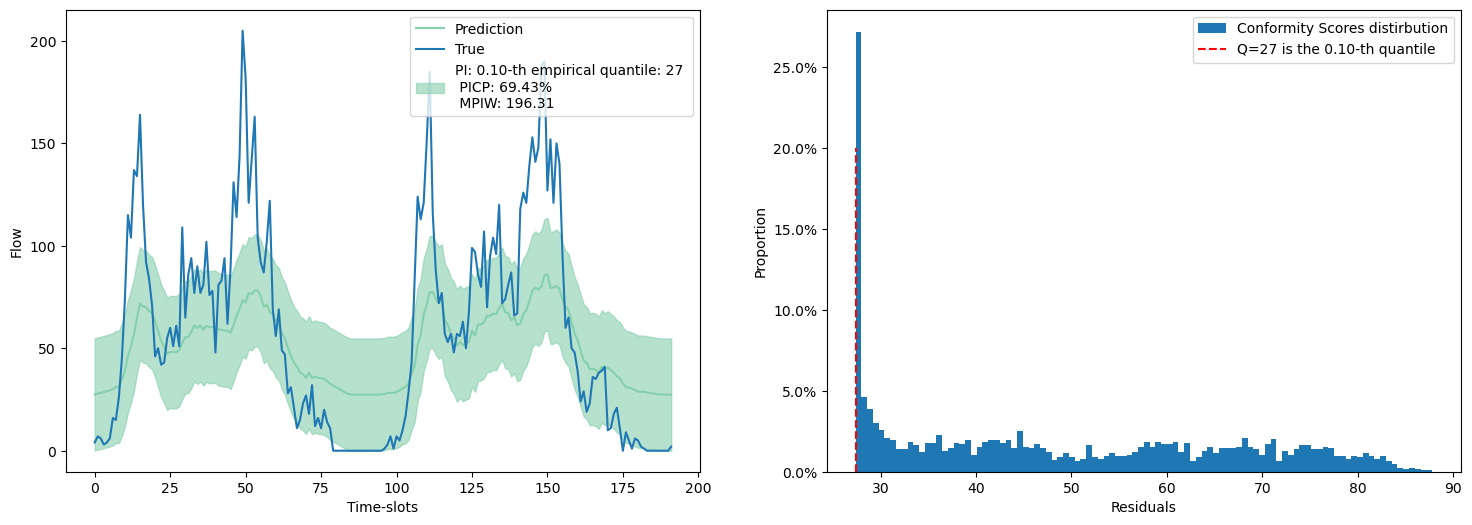

In [18]:
plot_conformal_bands(preds,Y_true,trainer.quantile_order,pi,trainer.conformity_scores,bins = 100)

In [27]:
# On veut vérifier que sur la dataset de calibration, on ait un PICP de 90% (car model fait pour).
for training_mode in ['train','validate','cal','test']:
    (preds,Y_true) = trainer.test_prediction(allow_dropout = False,training_mode = training_mode)
    preds = dataset.unormalize_tensor(preds)
    Y_true = dataset.unormalize_tensor(Y_true)
    pi = PI_object(torch.cat([preds,preds],dim=-1) ,Y_true,alpha,Q=trainer.Q)
    print(f"Training mode: {training_mode}, PICP: {pi.picp}, MPIW: {pi.mpiw}, len preds: {preds.size(0)}\n")

Training mode: train, PICP: 0.4142857142857143, MPIW: 196.3149871826172, len preds: 1358

Training mode: validate, PICP: 0.6944616063548102, MPIW: 196.31495666503906, len preds: 1133

Training mode: cal, PICP: 0.6590975968612065, MPIW: 196.3149871826172, len preds: 2039

Training mode: test, PICP: 0.6943071491615181, MPIW: 196.3149871826172, len preds: 1133



# Historical data-based method:
Suppose que les données de trafic suivent une distribution avec des pattern qui se répètent à travers le temps. Le PI serait basé sur leur distribution.

Le PI est alors $$[\mu_{i}^{t} - \alpha * \sigma_{i}^{t} , \mu_{i}^{t} + \alpha * \sigma_{i}^{t}] \phantom{abc} \forall i,t \in \mathcal{N}\times \mathcal{T} $$

Avec : 
- $\mathcal{N}$ l'ensemble des unités spatiales considérés (ex : les 40 stations de métro)
- $\mathcal{T}$ l'ensemble des class temporelle (ex : l'ensemble des lundi 8:30)
- $\alpha$ un coefficient qui sert de sueil (1*std ou 3*std)



In [14]:
def historical_data_based_method(train_df,method = 'week and hour',time_step_per_hour = 4):
    spatial_units = list(train_df.columns)
    train_df.index.name = 'datetime'
    train_df = train_df.reset_index()

    # Add columns weekday, hour, minutes : 
    if method == 'week and hour':
        train_df['weekday'] = train_df.datetime.dt.weekday
        train_df['hour'] = train_df.datetime.dt.hour
        groupby_col = ['weekday','hour']
        if time_step_per_hour > 1:
            train_df['minute'] = train_df.datetime.dt.minute
            groupby_col = groupby_col + ['minute']

    # Get 'mean' and 'std' for each spatial unit and temporal class (weekday,hour,min): 
    train_df = train_df.groupby(groupby_col).agg({c : ['mean','std'] for c in spatial_units} )
    
    return(train_df)

# Exemple to use it : 
if False:
    train_df = dataset_in.df_train
    train_df = historical_data_based_method(train_df)
    train_df.head()

## Deep Quantile Regression (DQR)
Ici, le modèle sert de **quantile estimator**.
- Au lieu de prédire une seule sortie, **on prédit autant de sortie qu'on veut de quantile**
- **On adapte la fonction objective**, qui minimisera la moyenne des erreur faite sur chacune des sorties.

Chaque erreur de sorties est associé à un quantile. 

Exemple : prenons $\alpha$ = 0.1
- Si $\hat{y} > y$, alors $L = 0.9(\hat{y}-y)$
- Si $\hat{y} < y$, alors $L = 0.1(y-\hat{y})$

Dans les deux cas on doit minimiser l'écart absolue $|y-\hat{y}|$
Mais, on aura tendance à privilégier (dans 90‰ des cas ? Est-ce si simple ?) les moments où $\hat{y} < y$

Ceci fonctionne pour la sortie associé au quantile $\alpha = 0.1$. 

Mais comme il y a $n$ sortie, associé à $n$ quantiles différents, chacun va adapter les poids - en particulier de la dernière couche - pour prédire le $\hat{y}_{i}$ adapté au quantile $\alpha_{i}$.

In [12]:
quantiles = torch.Tensor([0.025,0.1,0.5,0.9,0.975])
epochs = 100

C_outs[-1] = len(quantiles)  #On mets autant de sortie qu'on veut calculer de quanitles
model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1,dropout = 0.3)
quantile_loss = QuantileLoss(quantiles)  # On associe notre nouvelle loss

trainer = train_valid_model(model,data_loader,epochs,lr,momentum,loss_function = quantile_loss)
(test_pred,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.5min 


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


#### Plotting 

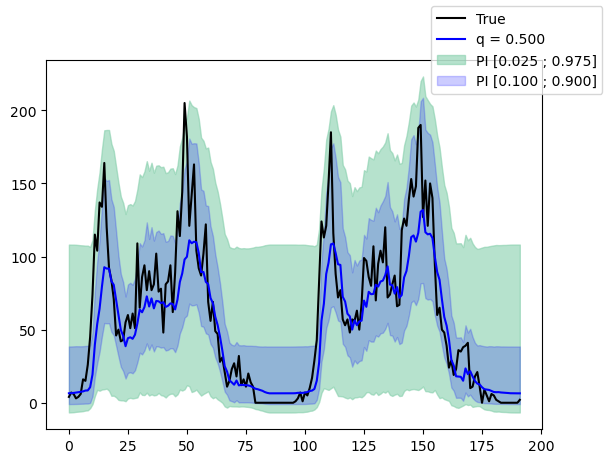

In [14]:
fig, ax = plt.subplots()
restricted_pred, restricted_true = test_pred[window_pred][:,0,:],Y_true[window_pred][:,0,0]
xaxis = np.arange(len(restricted_pred))
restricted_pred = restricted_pred.unbind(-1)  #List of prediction associated to quantiles 


# plot true
ax.plot(xaxis,restricted_true, label = 'True', color = 'black')

# plot mean :
q = 0.5
ind = int((len(restricted_pred)/2))
ax.plot(xaxis,restricted_pred[ind],label = f"q = {'{:.3f}'.format(q)}", alpha = 1,color = 'blue')

# plot prediction
colors = ['#86cfac','blue','lightblue']
for pos in range(ind):

    q = quantiles[pos].numpy().item()
    upper = restricted_pred[pos]
    lower = restricted_pred[len(restricted_pred)-1-pos]
    grid = xaxis.ravel()
    ax.fill_between(grid,lower,upper, label = f"PI [{'{:.3f}'.format(q)} ; {'{:.3f}'.format(1-q)}]",alpha=0.6/(1+2*pos), color=colors[pos])

fig.legend()

## Conformalized Quantile Regression
Provient d'un article de math [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf). Ils ont pour but de construire un 'marginal distribution-free prediction interval' avec un taux d'erreur controlé (1-$\alpha$)

**Dans leur papier, il ne parlent uniquement de prediction intervalle, mais pas de PI ou de Probability Interval**

Lorsqu'ils parlent de 'Deep Quantile Regression (DQR)' dans [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf), c'est à celle-ci qu'ils font réferrence (même si pas extrêmement clair, peut être plutôt CQR...). 

C'est très inspiré de la **conformal prediction**. En fait ils combinent conformal prediction et quantile regression.
- Split le training set en 2 : proper training set $\mathcal{I_1}$ et calibration set $\mathcal{I_2}$
- Entrainent 2 quantile regressor (un pour lower band et l'autre pour upper band du PI)
- Ensuite, en s'aidant du calibration set, ils 'conformalize', et donc si nécessaire ils corrigent le PI. Ce nouvel intervalle (contrairement a celui généré initialement) garanti de vérifier (quelque soit le choix d'estimateur de quantile regressor ou de son accuracy) : $$\mathbb{P}\{Y_{n+1} \in C(X_{n+1}) \} \ge 1-\alpha$$
- Diffère de la conformal prediction dans le sens où ils calibrent le PI en utilisant un **conditional quantile** regression (là où la méthode standard utilise conditional mean regression)

Le but de la Conditional Quantile Regression est d'estimer un certain quantile (mediane, 0.90 etc) de Y conditionnellement à X. On appel F la **conditional distribution function**  de Y sachant X:
$$F(y | X = x) = \mathbb{P} \{ Y \leq y |  X = x \} $$
Et la **$\alpha^{th}$ conditional quantil function** est : 
$$ q_{\alpha}(x) = \inf \{y \in \mathbb{R}, F(y|X=x) \ge \alpha  \}$$
Alors, en fixant $\alpha_{l} = \alpha /2$ et $\alpha_{u} = 1- \alpha /2$, on défini un Interval de prédiction à $1-\alpha \%$  (ou à taux d'erreur $\alpha$ / PI for Y given X=x, with miscoverate rate $\alpha$ )
$$ C(x) = [ q_{\alpha_{l}}(x),q_{\alpha_{u}}(x) ]$$

Par construction, l'intervale $C(x)$ vérifie : 
$$\mathbb{P}\{Y \in C(x) | X=x \} \ge 1-\alpha $$

Comme tout est conditionnellement à $X$, la largeur de l'interval $C$ dépend de X, et l'incertitude sur Y est exprimé par la largeur de l'interval.

Méthode de construction :
-----
Soit $\mathcal{A}$ un algo de quantile regression, on entraine 2 Conditional Quantile Function $\hat{q}_{\alpha_l}$ et $\hat{q}_{\alpha_u}$ sur $\mathcal{I_1}$ :$$\{\hat{q}_{\alpha_l},\hat{q}_{\alpha_u} \} \longleftarrow \mathcal{A}(\{(X_i,Y_i),i\in \mathcal{I}_{1} \})$$
On calcul ensuite les **conformity scores** pour quantifier les erreurs faites par le PI estimé $\hat{C}(x)$ : $$E_{i} = \max \{ \hat{q}_{\alpha_l}(X_i)- Y_i, Y_i - \hat{q}_{\alpha_u}(X_i) \} $$  
Dans le cas où $Y_i$ est dans l'intervalle $[\hat{q}_{\alpha_l}(X_i), \hat{q}_{\alpha_u}(X_i)]$, le conformity score est négatif, sinon il est positif. 

Et alors, on défini $Q_{1-\alpha}(E,\mathcal{I}_2)$ comme dans la conformal prediction : 
$$Q_{1-\alpha}(E,\mathcal{I}_2) = (1-\alpha)\left( 1+\frac{1}{|\mathcal{I}_2 |} \right) ^{th}\text{ quantile empirique de } \{E_i, i\in \mathcal{I}_2\} $$ 

On produit alors le PI $C(X_{n+1})$ :
$$C(X_{n+1}) = [\hat{q}_{\alpha_l}(X_{n+1})- Q_{1-\alpha}(E,\mathcal{I}_2),\phantom{a} \hat{q}_{\alpha_u}(X_{n+1})+Q_{1-\alpha}(E,\mathcal{I}_2) ] $$ 

La largeur de l'interval est d'au moins $2Q_{1-\alpha}(E,\mathcal{I}_2)$, mais au moins les bornes $\hat{q}_{\alpha_l}$ et $\hat{q}_{\alpha_u}$ ne sont pas d'écarts constant. Et cela [satisfait l'hyppothèse de recouvrement](https://arxiv.org/pdf/1905.03222.pdf) $\mathbb{P}\{Y \in \hat{C}(x) | X=x \} \ge 1-\alpha $

In [8]:
def load_model():
    if config['model_name'] == 'CNN': 
        model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=seq_length, padding = 1,dropout = dropout)
    if config['model_name'] == 'MTGNN': 
        model = gtnet(gcn_true, buildA_true, gcn_depth, num_nodes, device, 
                    predefined_A=predefined_A, static_feat=static_feat, 
                    dropout=dropout, subgraph_size=subgraph_size, node_dim=node_dim, 
                    dilation_exponential=dilation_exponential, conv_channels=conv_channels, residual_channels=residual_channels, 
                    skip_channels=skip_channels, end_channels=end_channels, seq_length=seq_length, in_dim=c_in, out_dim=out_dim, 
                    layers=layers, propalpha=propalpha, tanhalpha=tanhalpha, layer_norm_affline=layer_norm_affline)
        
    if config['model_name'] == 'LSTM':
        model = RNN(seq_length,h_dim,C_outs, num_layers,bias = bias,dropout = dropout,bidirectional = bidirectional,lstm = True)
        # nn.LSTM(input_size = c_in, hidden_size = h_dim, num_layers=num_layers,bias=bias,batch_first=batch_first,dropout=dropout,bidirectional=bidirectional)
    if config['model_name'] == 'GRU':
        model = RNN(seq_length,h_dim,C_outs, num_layers,bias = bias,dropout = dropout,bidirectional = bidirectional, gru = True)
        #self.rnn = nn.GRU(input_size = c_in, hidden_size = h_dim, num_layers=num_layers,bias=bias,batch_first=batch_first,dropout=dropout,bidirectional=bidirectional)
    if config['model_name'] == 'RNN':
        model = RNN(seq_length,h_dim,C_outs, num_layers, nonlinearity = 'tanh',bias = bias,dropout = dropout,bidirectional = bidirectional)
        #self.rnn = nn.RNN(input_size = c_in, hidden_size = h_dim, num_layers=num_layers,nonlinearity=nonlinearity,bias=bias,batch_first=batch_first,dropout=dropout,bidirectional=bidirectional) 
    return(model)


config = get_config(model_name = 'RNN')
config['conformity_scores_type'] ='max_residual' # 'max_residual_plus_middle'
config['seq_length'] = L


In [9]:
#quantiles = torch.Tensor([0.025,0.1,0.5,0.9,0.975])
#C_outs[-1] = len(quantiles)  #On mets autant de sortie qu'on veut calculer de quanitles

def load_train_calib_model(config):
    # Parameters selected randomly:
    for key in config.keys():
        if type(config[key]) != list:
            globals()[key] = config[key]
        else:
            ind = random.randint(0,len(config[key])-1)
            globals()[key] = config[key][ind]
    print('_'.join([f'{k}_{globals()[k]}' for k in config.keys()]))


    results = dict(epochs = epochs, batch_size = batch_size, lr = lr, momentum = momentum, 
               dropout = dropout, L =L, calib_prop =calib_prop, alpha = alpha, c_in = c_in)
                 #c_outs = '_'.join([str(out) for out in C_outs]),
                 #h_dims =  '_'.join([str(h) for h in H_dims])

    # Loss, quantiles init
    #prop_coverage = 1-alpha
    try: 
        out_dim = C_outs[-1]
    except:
        print("Pas de 'C_outs")
    assert out_dim != 1, "Output dimension = 1, which doesn't work with quantiles and quantile loss"
    quantiles = torch.Tensor([alpha/2,1-alpha/2])
    C_outs[-1] = len(quantiles) # =2
    quantile_loss = QuantileLoss(quantiles)  # On associe notre nouvelle loss
    
    # load data model 
    data_loader_obj = DictDataLoader(U,Utarget,train_prop,valid_prop,validation = 'classic', shuffle = True, calib_prop=calib_prop)
    data_loader = data_loader_obj.get_dictdataloader(batch_size)

    # Load model : 
    model = load_model()
    # Training and Calibration :
    optimizer = SGD(model.parameters(),lr=lr,momentum = momentum)
    trainer = Trainer(model,data_loader,epochs,optimizer,quantile_loss,scheduler = None)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
    trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
    Q = trainer.conformal_calibration(alpha,dataset,conformity_scores_type =conformity_scores_type)  # calibration for PI 90%
      
    (preds,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])

    return(trainer,Q,preds,Y_true,results)


trainer,Q,preds,Y_true,results = load_train_calib_model(config)
# get PI
pi = trainer.CQR_PI(preds,Y_true,alpha,Q)

# update results:
results['MPIW'] = pi.mpiw
results['PICP'] = pi.picp  
results['Q'] = pi.Q.mean().item()
results['last train loss'] = trainer.train_loss[-1]
results['last valid loss'] = trainer.valid_loss[-1] 

model_name_RNN_epochs_30_lr_0.0001_batch_size_64_dropout_0.2_calib_prop_0.5_alpha_0.1_device_cpu_c_in_1_h_dim_64_C_outs_[16, 2]_num_layers_2_bias_True_bidirectional_False_conformity_scores_type_max_residual_seq_length_8
start training


epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.3min 


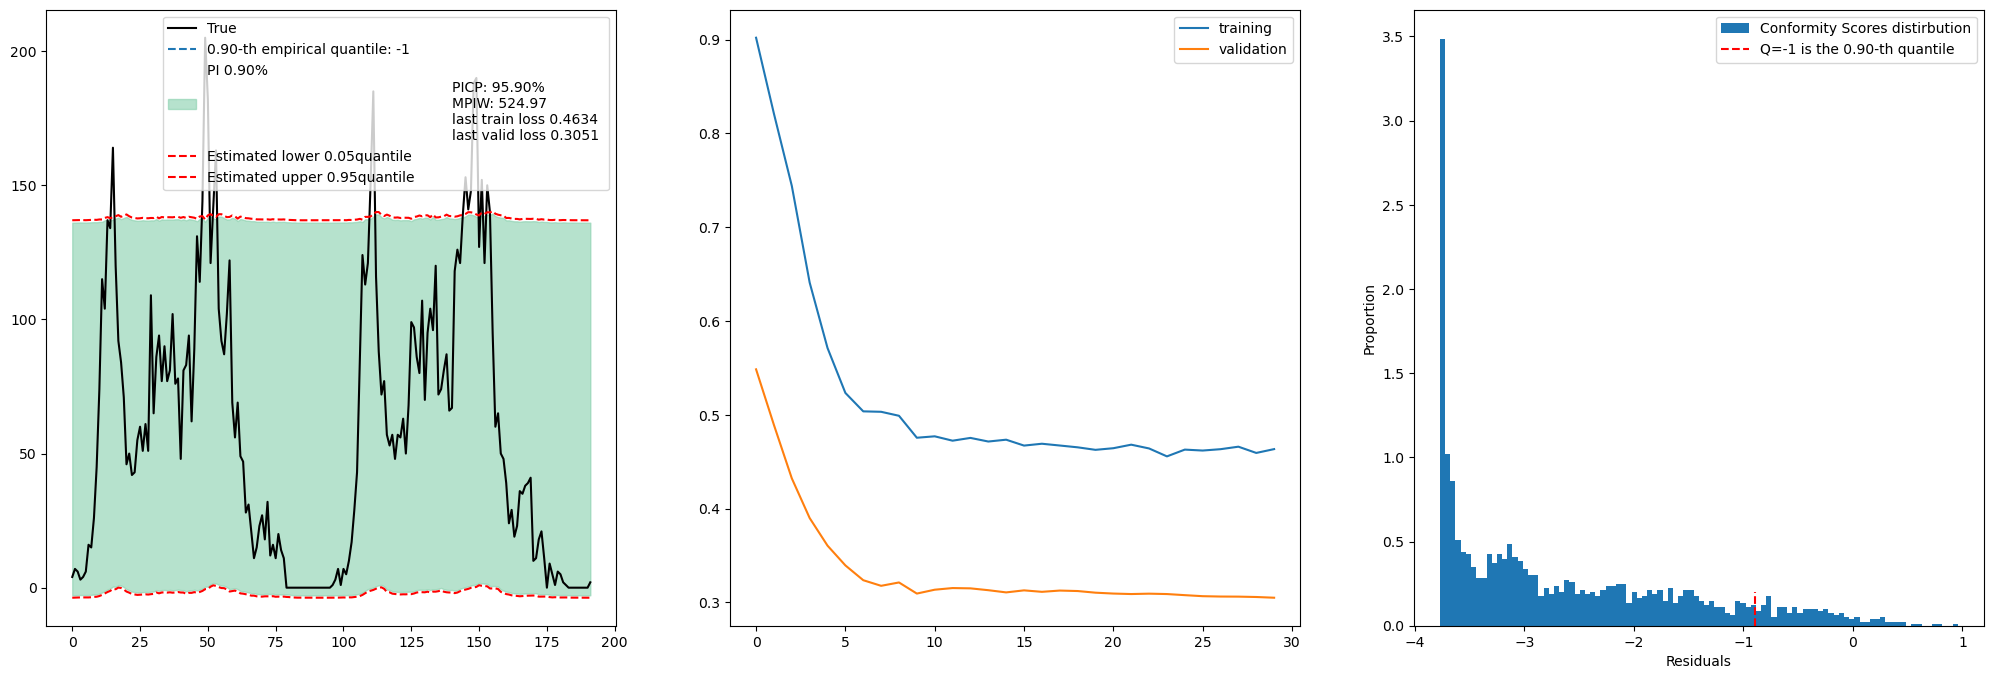

In [10]:
def plot_bands_CQR(preds,pi,window_pred,alpha,conformity_scores,results,bins = 100):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (25,8))
    lower_band,upper_band = pi.lower[...,0,0][window_pred],pi.upper[...,0,0][window_pred]
    restricted_true = Y_true[window_pred][:,0,0]

    xaxis = np.arange(len(restricted_true))

    # plot true
    ax1.plot(xaxis,restricted_true, label = 'True', color = 'black')

    # plot PI
    ax1.plot([0],[0],label = f"{'{:.2f}'.format(1-alpha)}-th empirical quantile: {'{:.0f}'.format(pi.Q[0,0,0].item())}",linestyle = 'dashed')
    grid = xaxis.ravel()
    ax1.fill_between(grid,lower_band,upper_band, label = f"PI {'{:.2f}'.format(1-alpha)}% \n\
                                                        PICP: {'{:.2%}'.format(pi.picp)} \n\
                                                        MPIW: {'{:.2f}'.format(pi.mpiw)} \n\
                                                        last train loss {'{:.4f}'.format(results['last train loss'])} \n\
                                                        last valid loss {'{:.4f}'.format(results['last valid loss'])} ",
               alpha=0.6, color='#86cfac')

    # Lower and upper band 
    ql = preds[window_pred][:,0,0]
    qu = preds[window_pred][:,0,1]
    ax1.plot(np.arange(len(ql)),ql,label = f'Estimated lower {alpha/2}quantile',color = 'red',linestyle = 'dashed')
    ax1.plot(np.arange(len(qu)),qu,label = f'Estimated upper {1-alpha/2}quantile',color = 'red',linestyle = 'dashed')

    ax1.legend()
    
    
    ax2.plot(np.arange(len(trainer.train_loss)),trainer.train_loss, label = 'training')
    ax2.plot(np.arange(len(trainer.valid_loss)),trainer.valid_loss, label = 'validation')
    ax2.legend()

    ax3.hist(conformity_scores,bins = bins, label = 'Conformity Scores distirbution',density = True)
    ax3.plot([pi.Q[0,0,0],pi.Q[0,0,0]],[0,0.2],color = 'red', linestyle = 'dashed',label = f"Q={'{:.0f}'.format(pi.Q[0,0,0].item())} is the {'{:.2f}'.format(1-alpha)}-th quantile")
    #ax3.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Proportion')
    ax3.legend()
    
    plt.show()

conformity_scores = trainer.conformity_scores[:,0,0]
plot_bands_CQR(preds,pi,window_pred,alpha,conformity_scores,results)  

In [98]:
# Sous entend que pour cet entrainement, le score moyen de non conformité est nul.
# Vérifions : 
model.eval()
with torch.no_grad():
    x_b,y_b = next(iter(data_loader['cal']))
    y_pred_b = trainer.model(x_b)
    ql,qu = y_pred_b[...,0].unsqueeze(-1),y_pred_b[...,1].unsqueeze(-1)
    ql,qu,y_b = dataset.unormalize_tensor(ql),dataset.unormalize_tensor(qu),dataset.unormalize_tensor(y_b)
    score_l = ql - y_b
    score_u = y_b - qu

    score_l_station1,score_u_station1 = score_l[:,0,0],score_u[:,0,0]


In [ ]:
# Nombre d'éléments dont le score de Ql > score Qu  (et inversement) :
(score_l_station1 > score_u_station1).sum(),(score_l_station1 < score_u_station1).sum()

# Moyenne de l'ensemble conformity scores où score Ql > score Qu :
torch.sum((score_l_station1 > score_u_station1)*score_l_station1)/(score_l_station1 > score_u_station1).sum()

# Moyenne de l'ensemble conformity scores où score Qu > score Ql :
torch.sum((score_l_station1 < score_u_station1)*score_u_station1)/(score_l_station1 < score_u_station1).sum()

# Mask sur score Ql quand il est plus petit que score Qu (et inversement) :
(score_l_station1 > score_u_station1)*score_l_station1,(score_l_station1 < score_u_station1)*score_u_station1

# score Ql et score Qu : 
score_l_station1,score_u_station1

## Hyperparameter Tuning 
- Implementation avec Ray
- Hyperparameter Tuning 
- Sauvegarde des meilleurs paramètres 
- Entrainement avec les meilleurs paramètres
- Sauvegarde du meilleur modèle (checkpoint)
- Load du meilleur modèle 
- Calibration avec Calibration-Set 
- Test avec Testing-Set
- Compute le PI associé et plotting 

In [2]:
import ray
from ray import tune
from ray.tune.schedulers import HyperBandScheduler
from ray.tune.schedulers import ASHAScheduler

In [3]:
def ray_trainer(config):
    # Load Data
    data_loader_obj = DictDataLoader(U,Utarget,config['train_prop'],config['valid_prop'],validation = config['validation_type'], shuffle = True, calib_prop=config['calib_prop'])
    data_loader = data_loader_obj.get_dictdataloader(config['batch_size'])

    # Load Model
    if config['model_name'] == 'cnn':
        model  = CNN(config['c_in'], config['H_dims'], config['C_outs'], kernel_size = (2,), L=config['seq_length'], padding = 1,dropout = config['dropout'])
    
    # Optimizer and loss
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"],momentum = config['momentum'])
    if config['loss_function'] == 'quantile_loss':
        loss_function = QuantileLoss(quantiles)
    else : 
        loss_function = nn.MSELoss()
    
    # Train and Valid model
    trainer = Trainer(model,data_loader,config['epochs'],optimizer,loss_function,scheduler = None, ray = True)  
    trainer.train_and_valid(mod = 1000, alpha = config['alpha'], dataset = dataset)  

def name_trial(trial):
    return '{}'.format(trial.trial_id.split('_')[-1])

In [4]:
# Config
config = dict(model_name= 'cnn',
            epochs = 300, 
            lr = tune.loguniform(lower = 1e-5,upper = 1e-2),
            batch_size = tune.choice([32,64,128]),
            seq_length = L,
            dropout = tune.choice([0.1,0.3,0.7,0.9]),
            alpha = 0.1,
            c_in = 1, 
            C_outs = tune.choice([[16,16,2],[32,32,2],[32,16,2],[16,32,2],[32,2],[16,2]]),
            H_dims = tune.choice([[16,32],[32,16],[16,16],[32,32],[16,16,16],[32,16,16],[16,16,32],[32,32,32]]),
            train_prop = train_prop,
            valid_prop = 0.2,
            calib_prop = 0.3,
            validation_type = 'classic',
            loss_function = 'quantile_loss',
            momentum = tune.uniform(0.9,1),    
                ) 

# Qunatiles to predict :

quantiles = torch.Tensor([config['alpha']/2,1-config['alpha']/2])

In [5]:
ray.shutdown() 
ray.init()
! rm -rf ~/ray_results/tuning_test   #Remove the save folder if it already exists

2024-02-26 18:33:21,363	ERROR services.py:1207 -- Failed to start the dashboard , return code 0
2024-02-26 18:33:21,365	ERROR services.py:1232 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2024-02-26 18:33:21,504	ERROR services.py:1276 -- 
The last 20 lines of /tmp/ray/session_2024-02-26_18-33-18_706464_18659/logs/dashboard.log (it contains the error message from the dashboard): 
    return future.result()
  File "/Users/romainrochas/opt/anaconda3/envs/ray_torch/lib/python3.9/site-packages/ray/dashboard/dashboard.py", line 75, in run
    await self.dashboard_head.run()
  File "/Users/romainrochas/opt/anaconda3/envs/ray_torch/lib/python3.9/site-packages/ray/dashboard/head.py", line 327, in run
    self.http_server = await self._configure_http_server(modules)
  File "/Users/romainrochas/opt/anacond

In [6]:
asha = ASHAScheduler(
        metric="Loss_model",
        mode="min",
        max_t=100,
        grace_period=10,   #minimum of run epoch 
        reduction_factor=2,
    )

# Tuning 
analysis = tune.run(
lambda x: ray_trainer(x),
config=config,
num_samples= 3,  # Increase num_samples for more random combinations
scheduler = asha,
progress_reporter=tune.CLIReporter(metric_columns=["Loss_model","MPIW","PICP"]),   #  Permet un meilleur affichage, et permet de reporter l'évolution de la loss (ici "mse_test") dans le dashboard 
name = 'tuning_test',  #Define the save folder    
trial_name_creator=name_trial,   # Define the name of each Trial according to the function "name_trial" 
    )

# Get Results
df_tuning = analysis.results_df
print(analysis.get_best_config(metric = 'Loss_model', mode = 'min'))  # Get the best config
df_tuning

2024-02-26 18:33:25,525	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-02-26 18:33:25,526	WARNING syncer.py:260 -- You are using remote storage, but you don't have `fsspec` installed. This can lead to inefficient syncing behavior. To avoid this, install fsspec with `pip install fsspec`. Depending on your remote storage provider, consider installing the respective fsspec-package (see https://github.com/fsspec).


== Status ==
Current time: 2024-02-26 18:33:26 (running for 00:00:00.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 0/6 CPUs, 0/0 GPUs
Result logdir: /Users/romainrochas/ray_results/tuning_test
Number of trials: 3/3 (3 PENDING)
+--------------+----------+-------+-------------+--------------+--------------+-----------+-------------+------------+
|   Trial name | status   | loc   | C_outs      | H_dims       |   batch_size |   dropout |          lr |   momentum |
|--------------+----------+-------+-------------+--------------+--------------+-----------+-------------+------------|
|        00000 | PENDING  |       | [32, 32, 2] | [32, 16, 16] |          128 |       0.3 | 7.32834e-05 |   0.930371 |
|        00001 | PENDING  |       | [16, 2]     | [16, 16]     |          128 |       0.7 | 0.000130684 |   0.921787 |
|        00002 | PENDING  |       | [16, 2]     | [32, 32, 32] |         

2024-02-26 18:33:27,887	WARNING worker.py:2037 -- Warning: The actor ImplicitFunc is very large (28 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(<lambda> pid=18695) start training
(<lambda> pid=18695) pi.mpiw: 79.6561050415039, pi.picp: 1.0
(<lambda> pid=18695) epoch: 0 
(<lambda> pid=18695)  min\epoch : 0.01
(<lambda> pid=18695) Estimated time for training: 4.4min 
(<lambda> pid=18696) start training [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(<lambda> pid=18695) pi.mpiw: -71.08062744140625, pi.picp: 0.0 [repeated 3x across cluster]
(<lambda> pid=18696) epoch: 0  [repeated 2x across cluster]
(<lambda> pid=18696)  min\epoch : 0.05 [repeated 2x across cluster]
(<lambda> pid=18696) Estimated time for training: 14.0min  [repeated 2x across cluster]
(<lambda> pid=18695) pi.mpiw: -93.14997863769531, pi.picp: 0.0
(<lambda> pid=18695) pi.mpiw: -110.49222564697266, pi.picp: 0.0
(<lambda> pid=18695) pi.mpiw: -127.08306121826172, pi.picp: 0.0 [repeated 2x acr

Trial name,Loss_model,MPIW,PICP
00000,0.685421,-62.7099,0
00001,0.188537,-160.458,0
00002,0.171209,-40.9887,0


== Status ==
Current time: 2024-02-26 18:33:36 (running for 00:00:11.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 3.0/6 CPUs, 0/0 GPUs
Result logdir: /Users/romainrochas/ray_results/tuning_test
Number of trials: 3/3 (3 RUNNING)
+--------------+----------+-----------------+-------------+--------------+--------------+-----------+-------------+------------+--------------+---------+--------+
|   Trial name | status   | loc             | C_outs      | H_dims       |   batch_size |   dropout |          lr |   momentum |   Loss_model |    MPIW |   PICP |
|--------------+----------+-----------------+-------------+--------------+--------------+-----------+-------------+------------+--------------+---------+--------|
|        00000 | RUNNING  | 127.0.0.1:18694 | [32, 32, 2] | [32, 16, 16] |          128 |       0.3 | 7.32834e-05 |   0.930371 |              |         |        |
|        00001

2024-02-26 18:36:44,796	INFO tune.py:1148 -- Total run time: 199.27 seconds (199.15 seconds for the tuning loop).


== Status ==
Current time: 2024-02-26 18:36:44 (running for 00:03:19.16)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.18727718263499551 | Iter 40.000: -0.21538331136041686 | Iter 20.000: -0.30573923850558626 | Iter 10.000: -0.5298277561972863
Logical resource usage: 1.0/6 CPUs, 0/0 GPUs
Result logdir: /Users/romainrochas/ray_results/tuning_test
Number of trials: 3/3 (3 TERMINATED)
+--------------+------------+-----------------+-------------+--------------+--------------+-----------+-------------+------------+--------------+-----------+--------+
|   Trial name | status     | loc             | C_outs      | H_dims       |   batch_size |   dropout |          lr |   momentum |   Loss_model |      MPIW |   PICP |
|--------------+------------+-----------------+-------------+--------------+--------------+-----------+-------------+------------+--------------+-----------+--------|
|        00000 | TERMINATED | 127.0.0.1:18694 | [32, 32, 2] | [32, 16, 16] |          128 |       0

,Loss_model,MPIW,PICP,time_this_iter_s,done,training_iteration,date,timestamp,time_total_s,pid,...,config/alpha,config/c_in,config/C_outs,config/H_dims,config/train_prop,config/valid_prop,config/calib_prop,config/validation_type,config/loss_function,config/momentum
trial_id,,,,,,,,,,,,,,,,,,,,,
25696_00000,0.685421,-62.709946,0.0,1.512946,True,10,2024-02-26_18-33-51,1708968831,17.041411,18694,...,0.1,1,"[32, 32, 2]","[32, 16, 16]",0.6,0.2,0.3,classic,quantile_loss,0.930371
25696_00001,0.188537,-160.458221,0.0,0.585298,True,100,2024-02-26_18-34-37,1708968877,63.455682,18695,...,0.1,1,"[16, 2]","[16, 16]",0.6,0.2,0.3,classic,quantile_loss,0.921787
25696_00002,0.171209,-40.988743,0.0,1.782961,True,100,2024-02-26_18-36-44,1708969004,190.662904,18696,...,0.1,1,"[16, 2]","[32, 32, 32]",0.6,0.2,0.3,classic,quantile_loss,0.994890


In [ ]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir ~/ray_results/tuning_test

## Quantile Estimation from Data
Généralement, on estime la **moyenne d'une prédiction conditionnellement à ses données**  en minimisant la somme des carrés des residuals des points d'entrainement : 
$$ \hat \mu (x) = \mu(x,\hat{\theta}) $$
$$ \hat{\theta} = \argmin\limits_{\theta} \frac{1}{n} \sum\limits_{i=1}^{n} (Y_{i} - \mu(X_{i},\theta))^{2} + \mathcal{R}(\theta)$$
où $\theta$ représente les paramètres du modèle, $\mu (x,\theta)$ la fonction de regression, $\mathcal{R}$ représente une régularisation (potentielle)

De manière analogue, on peut estimer une conditional quantile function $q_{\alpha}$ de Y sachant X=x  : 
$$\hat q_{\alpha}(x) = f(x,\hat{\theta}) $$
$$ \hat{\theta} = \argmin\limits_{\theta} \frac{1}{n} \sum\limits_{i=1}^{n} \rho _{\alpha}(Y_{i}, f(X_{i},\theta)) + \mathcal{R}(\theta)$$
où $f(x,\theta)$  représente la quantile regression function, et $\rho _{\alpha}$ est la losse function, (appelé 'pinball loss' ou 'check function').
$$ \rho = \alpha (y-\hat{y}) \text{ si } y-\hat{y} > 0\text{, et }(1-\alpha)*(\hat{y}-y)\text{ sinon} $$

Cela permet d'avoir une estimation de l'intervalle de prédiction $\hat{C}(x)$:
$$\hat{C}(x) = [\hat{q}_{\alpha_{l}}(x), \hat{q}_{\alpha_{u}}(x)] $$

**Limites** : l'hyppothèse de recouvrement $\mathbb{P}\{Y \in \hat{C}(x) | X=x \} \ge 1-\alpha $ n'est pas garanti. 

# [QuanTraffic](https://github.com/wuyingvia/QUANTRAFFIC/blob/151a83dfb260732c2e19215f3c3c8cf3190f72b7/main.py#L161)
Etapes de train, valid, calib : 
---
 - Train_valid complètement le model :
       en sauvegardant la meilleur valid, Quantile Loss, et optimizer Adam ou RMSprop)
 - Calibre le model : 
        - Load le meilleur modèle retenu lors du train_valid 
        - Fait la prédiction du PI sur Calibration set (YS_pred_0 et YS_pred_1) + unormalize les predictions. 
            - Les deux bornes sont séparée en YS_0_train, YS_1_train en prenant la première moitiée des éléments de YS_pred_0 et de YS_pred_1. YS_train  est également construit (contenant les deux bornes)
            - Ainsi qu'en YS_0_val, YS_1_val en prenant la seconde moitiée des éléments de YS_pred_0 et de YS_pred_1. YS_val  est également construit (contenant les deux bornes)
        - On calcule ensuite les residuals de  YS_0_train, YS_1_train par rapport à YS_train  (donc écart sur upper et lower band), puis concatene (récupere dim = 2, lower et upper)  [2*len_calib, Channel, Nodes]
        - Produit une 'corr_err_list' de dimension [n_grid+1, Channel, Nodes]  (3,C,N ???) qui contient l'ensemble des quantiles  torch.quantile(residual(c,n), alpha),  == calculé sur l'ensemble des time-slots ==
        
 - Test le model 


In [18]:
def split_true_pred_and_get_residuals(YS,YS_pred):
    YS_pred_0 = YS_pred[..., 0]
    YS_pred_1 = YS_pred[..., 1]
    print('YS_pred_0.shape, YS_pred_1.shape,', YS_pred_0.shape, YS_pred_1.shape)

    YS, YS_pred_0, YS_pred_1 = np.squeeze(YS), np.squeeze(YS_pred_0), np.squeeze(YS_pred_1)
    print('\n np.squeeze: \n YS.shape, YS_pred_0.shape, YS_pred_1.shape', YS.shape, YS_pred_0.shape, YS_pred_1.shape)

    # split some data
    split = int(YS.shape[0]* 0.5)

    YS_train = YS[:split]
    YS_0_train = YS_pred_0[:split]
    YS_1_train = YS_pred_1[:split]
    print('\n \n Split: \n YS_train.shape, YS_0_train.shape, YS_1_train.shape,',YS_train.shape, YS_0_train.shape, YS_1_train.shape)

    YS_val = YS[split:]
    YS_0_val = YS_pred_0[split:]
    YS_1_val = YS_pred_1[split:]
    print('YS_val.shape, YS_0_val.shape, YS_1_val.shape,',YS_val.shape, YS_0_val.shape, YS_1_val.shape)

    YS_1_train = YS_1_train * (YS_1_train>0)  
    print('\n \n Mask negative values: \n YS_1_train.shpae', YS_1_train.shape)

    error_low =  YS_train - YS_1_train
    error_high =  YS_0_train - YS_train
    err_dis = torch.cat([error_low,error_high])
    print('\n \n Compute error: \n err_dis.shape, error_low.shape, error_high.shape ', err_dis.shape, error_low.shape, error_high.shape)

    return(err_dis,YS,YS_pred_0,YS_pred_1,YS_val,YS_0_val,YS_1_val)

def get_corr_err(err_dis,error_quantile = 99, node = 40, channel = 3):
    ''' For each quantile slots :
    - Compute quantile of each tuple (Channel, Node) sur les residuals 'err_dis'. Calcule le quantile l'ensemble des time-slots. 
    - Then compute the percentage coverage and the mean length of PI thank to the upper band, lower band, and the True Value
    '''
    # return [error_q, seq, node]
    corr_err_list = []
    for q in range(0, error_quantile+1):
        q_n = []
        for n in range(node):
            q_t = []
            for t in range(channel):
                corr_err = torch.quantile(err_dis[:, t, n], q/error_quantile)
                q_t.append(corr_err)
            q_t = torch.stack(q_t)
            q_n.append(q_t)
        q_n = torch.stack(q_n).T
        corr_err_list.append(q_n)
    corr_err_list = torch.stack(corr_err_list)
    corr_err_list.size()
    return(corr_err_list)

def get_coverage_and_interval_len(YS,YS_pred_0,YS_pred_1,corr_err_list,n_quantile):
    ''' For each quantile :
    - Compute the upper and lower band of the prediction (according to the result predicted and the 'corr_err_list')
    - Then compute the percentage coverage and the mean length of PI thank to the upper band, lower band, and the True Value
    '''

    coverage_list = []
    interval_list = []
    for m in range(0, n_quantile+1):
      y_u_pred = YS_pred_0 + corr_err_list[m]
      y_l_pred = YS_pred_1 - corr_err_list[m]
      y_l_pred = y_l_pred * (y_l_pred >=0)
      mask = YS > 0

      coverage = torch.logical_and(y_u_pred >= YS, y_l_pred <= YS)
      coverage_a = torch.mean(coverage.float(),axis=0)
      coverage_list.append(coverage_a)
      interval_a = torch.mean(torch.abs(y_u_pred - y_l_pred),axis=0)       
      interval_list.append(interval_a)

    # torch.Size([sample, channel, node])
    coverage_list = torch.stack(coverage_list)
    interval_list = torch.stack(interval_list)

    print('\n \n coverage_list.shape, interval_list.shape: ',coverage_list.shape,interval_list.shape)
  
    return(coverage_list,interval_list)


def minmax_norm_coverage_and_interval(coverage_list,interval_list,node = 40, channel = 3):
    interval_nor = []
    for n in range(node):
        interval_n = []
        for t in range(channel):
            interval_ = (interval_list[:,t, n] - torch.min(interval_list[:,t, n])) /\
                        (torch.max(interval_list[:,t, n]) - torch.min(interval_list[:,t, n]))
            interval_n.append(interval_)
        interval_n = torch.stack(interval_n)
        interval_nor.append(interval_n)
    interval_nor = torch.stack(interval_nor).T

    coverage_nor = []
    for n in range(node):
        coverage_n = []
        for t in range(channel):
            coverage_ = (coverage_list[:,t, n] - torch.min(coverage_list[:,t, n])) /(
                    torch.max(coverage_list[:,t, n]) - torch.min(coverage_list[:,t, n]) + 1e-5)
            coverage_n.append(coverage_)
        coverage_n = torch.stack(coverage_n)
        coverage_nor.append(coverage_n)
    coverage_nor = torch.stack(coverage_nor).T 
    print('\n \n coverage_nor.shape, interval_nor.shape: ',coverage_nor.shape, interval_nor.shape)
    return(coverage_nor,interval_nor)

def get_calibration_table_according_different_lambda(corr_err_list,lambda_list,node = 40, channel = 3):
    cor_err = []
    lambda_list = torch.Tensor(lambda_list)
    for i in lambda_list:
        loss = - i * coverage_nor + (1 - i) * interval_nor
        index = torch.argmin(loss,axis=0).cpu().numpy() # l'index correspond à la quantile calibration qui donne la loss minimale
        err_t = []
        for t in range(channel):
            err_n = []
            for n in range(node):
                corr_err = corr_err_list[index[t,n], t, n]
                err_n.append(corr_err)
            err_n = torch.stack(err_n)
            err_t.append(err_n)
        err_i = torch.stack(err_t)
        cor_err.append(err_i)
    cor_err = torch.stack(cor_err)
    return(cor_err)

def get_best_index_associated_to_best_lambda(cor_err,YS_val,YS_0_val,YS_1_val,lambda_list,exp_q):
    # 选择期望的cor_err
    independent_coverage_l =[]
    for i in range(len(lambda_list)):
        y_u_pred = YS_0_val + cor_err[i]
        y_l_pred = YS_1_val - cor_err[i]

        y_l_pred = y_l_pred * (y_l_pred>0)
        mask = YS_val>0
        independent_coverage = torch.logical_and(torch.logical_and(y_u_pred >= YS_val, 
        y_l_pred <= YS_val), mask)
        m_coverage = torch.sum(independent_coverage)/torch.sum(mask)
        independent_coverage_l.append(m_coverage)
    m_coverage = torch.stack(independent_coverage_l)
    index = torch.argmin(torch.abs(m_coverage - exp_q))
    return(index)


# ===============================================================
# Application 
# ===============================================================
import torch
import numpy as np

n_quantile = 2 # ou 99

YS = torch.randn(32,3,40,1)
YS_pred = torch.randn(32,3,40,2)
print('YS.shape, YS_pred.shape,', YS.shape, YS_pred.shape)


# A la fin la 'calibration table' contient les residual values où l'index est la quantile calibration qui donne la loss minimale 
lambda_list = np.arange(0,41)/41   # Weight to control the balnce of PI and the coverage Ccov for a given node-prediction-window combination

err_dis,YS,YS_pred_0,YS_pred_1,YS_val,YS_0_val,YS_1_val = split_true_pred_and_get_residuals(YS,YS_pred)
corr_err_list = get_corr_err(err_dis,n_quantile)
coverage_list,interval_list = get_coverage_and_interval_len(YS,YS_pred_0,YS_pred_1,corr_err_list,n_quantile)
coverage_nor,interval_nor = minmax_norm_coverage_and_interval(coverage_list,interval_list,node = 40, channel = 3)
cor_err = get_calibration_table_according_different_lambda(lambda_list,node = 40, channel = 3)
index = get_best_index_associated_to_best_lambda(cor_err,YS_val,YS_0_val,YS_1_val,lambda_list,exp_q)

YS.shape, YS_pred.shape, torch.Size([32, 3, 40, 1]) torch.Size([32, 3, 40, 2])
YS_pred_0.shape, YS_pred_1.shape, torch.Size([32, 3, 40]) torch.Size([32, 3, 40])

 np.squeeze: 
 YS.shape, YS_pred_0.shape, YS_pred_1.shape torch.Size([32, 3, 40]) torch.Size([32, 3, 40]) torch.Size([32, 3, 40])

 
 Split: 
 YS_train.shape, YS_0_train.shape, YS_1_train.shape, torch.Size([16, 3, 40]) torch.Size([16, 3, 40]) torch.Size([16, 3, 40])
YS_val.shape, YS_0_val.shape, YS_1_val.shape, torch.Size([16, 3, 40]) torch.Size([16, 3, 40]) torch.Size([16, 3, 40])

 
 Mask negative values: 
 YS_1_train.shpae torch.Size([16, 3, 40])

 
 Compute error: 
 err_dis.shape, error_low.shape, error_high.shape  torch.Size([32, 3, 40]) torch.Size([16, 3, 40]) torch.Size([16, 3, 40])

 
 coverage_list.shape, interval_list.shape:  torch.Size([3, 3, 40]) torch.Size([3, 3, 40])

 
 coverage_nor.shape, interval_nor.shape:  torch.Size([3, 3, 40]) torch.Size([3, 3, 40])


## Bayesian Uncertainty Quantification: 
Vient de ce papier [Weight Uncertainty in Neural Networks, Blundell et al., 2015](https://arxiv.org/pdf/1505.05424.pdf)
- Modélise l'incertitude des paramètres du modèles en utilisant une fonction de vraissemblance. 
- Compute l'incertitude sur la donnée en approchant la distribution de proba sur les sortie du modèle

Dans le papier [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf) : consdièrent la distribution appriori comme loi normale (Gaussian priori distribution with 0 mean and 1 variance), et un MC sampling de 50.

## Variational Inference 
Essaye d'approximer la distribution à posteriori. En minimisant la Kullback-Leibler divergence entre la distribution estimée et la distribution a posteriori, on arrive a un problème d'optimisation. 

Méthode avec beaucoup de Biais, mais peut de ressource nécessaire.

## Markov Chaine Monte Carlo (MCMC)
Méthode sans biais, mais demande beaucoup de ressource